## Build a machine learning model to predict user will click the ad or not based on his experience and estimated salary for a given dataset

### Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import os
os.chdir('/home/admin1/PycharmProjects/Machine Learning using libraries/Classification/Datasets & pickled objects/')
import sys
sys.path.append('/home/admin1/PycharmProjects/Machine Learning using libraries/')
from ipynb.fs.full.ml_library import *

# reading dataset from file & storing it as pandas dataframe
social_network_data = pd.read_csv('Social_Network_Ads.csv')
social_network_data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


#### Using already done preprocessing steps from pickle file

In [2]:
import joblib
file = open('DataProcessingAdClick.pkl', 'rb')
features = joblib.load(file)
label = joblib.load(file)
sc_x = joblib.load(file)
file.close()

#### Separating out feature colums & label column 

In [3]:
x_values = social_network_data.loc[:,features].values
y_values = social_network_data.loc[:,label].values

In [4]:
x_values = sc_x.transform(x_values)

#### Splitting dataset into train set & test set

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
train_x_values, test_x_values, train_y_values, test_y_values = train_test_split(x_values, y_values, train_size=0.8, random_state=20)

### Building Support Vector Machine (SVM) model

In [6]:
from sklearn.svm import SVC

classifier = SVC()

#### Plotting learning curve

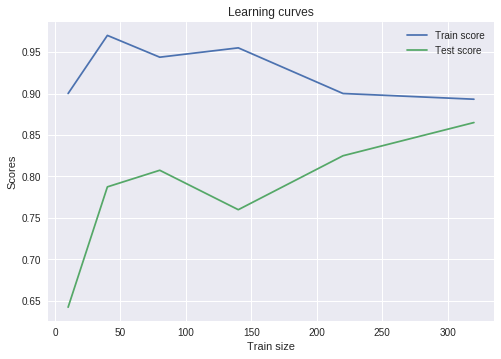

In [27]:
from sklearn.model_selection import learning_curve
# defining different train sizes
train_sizes= [10,40,80,140,220,320]

# creating x-axis values & y-axis values for learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator=classifier, X=x_values, y=y_values,
                                                        train_sizes=train_sizes, scoring='accuracy', cv=10)
# taking mean for each cross-validation
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean =  test_scores.mean(axis=1)

# plotting two line graphs for different test sizes 
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label='Train score')
plt.plot(train_sizes, test_scores_mean, label='Test score')
plt.xlabel('Train size')
plt.ylabel('Scores')
plt.title('Learning curves')
plt.legend()
plt.show()

In [29]:
# We need whole train set for training of classifier model

#### Setting optimal hyperparametrs using gridsearch

In [8]:
# defining hypermeters in list of dictionaries initially & changing these to optimal values after running this block of code
parameters = [{'C':[.1,.2,.3,.5,.6], 'kernel': ['rbf'], 'gamma':[.1,.2,.3]},
             {'C':[1,10,100,1000], 'kernel': ['linear'], 'gamma':[.1,.01,.001]},
             {'C':[1,10,100,1000], 'kernel': ['poly'], 'gamma':[.1,.01,.001]}]

# creating grid search object with paramters to try & 10-fold cross validation
grid_search = GridSearchCV(estimator=classifier, param_grid=parameters, scoring='accuracy', cv=10)

# fitting classifier model for given parameters for trial
grid_search = grid_search.fit(train_x_values, train_y_values)

# finding best accuracy & best parameters
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
best_accuracy, best_parameters

# unpacking hypermeters' optimal values to variable further will be feed to classifier model
C, gamma, kernel = best_parameters.values()
best_parameters, (C, gamma, kernel)

({'C': 0.3, 'gamma': 0.2, 'kernel': 'rbf'}, (0.3, 0.2, 'rbf'))

#### Checking cross-validation scores

In [9]:
accuracies = cross_val_score(estimator=classifier, X=x_values, y=y_values, cv=10)
accuracies, accuracies.mean(), accuracies.std()

(array([1.   , 0.85 , 0.9  , 1.   , 1.   , 0.85 , 0.825, 0.8  , 0.875,
        0.95 ]), 0.9049999999999999, 0.07314369419163896)

In [10]:
classifier = SVC(kernel=kernel, probability=True, C=C, gamma=gamma, random_state=0)
classifier.fit(x_values, y_values)

SVC(C=0.3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.2, kernel='rbf',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

#### Storing essential objects into pickle file

In [11]:
import joblib
file = open('SVMModelAdClick.pkl', 'wb')
joblib.dump(classifier, file)
file.close()

#### Storing predictions for test set

In [12]:
test_prediction = classifier.predict(test_x_values)

### Evaluating model against test set 

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
print(f'Confusion matrix:\n {confusion_matrix(test_y_values, test_prediction)}')
print(f'Accuracy score: {accuracy_score(test_y_values, test_prediction)}')
print(f'\nClassification report:\n {classification_report(test_y_values, test_prediction)}')

Confusion matrix:
 [[44  1]
 [ 5 30]]
Accuracy score: 0.925

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94        45
           1       0.97      0.86      0.91        35

    accuracy                           0.93        80
   macro avg       0.93      0.92      0.92        80
weighted avg       0.93      0.93      0.92        80



### Plotting colormap for  classification

#### 1 (blue) represents user purchased &  0 (red) represents user not purchased

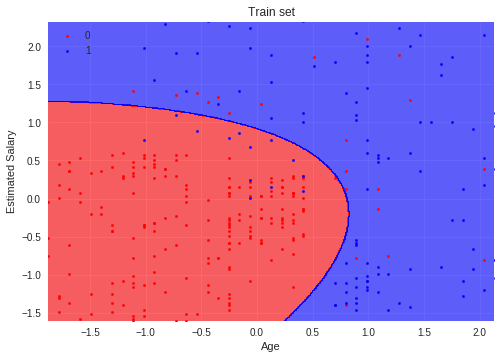

In [14]:
plot_colormap(train_x_values, train_y_values, classifier,'Train set')

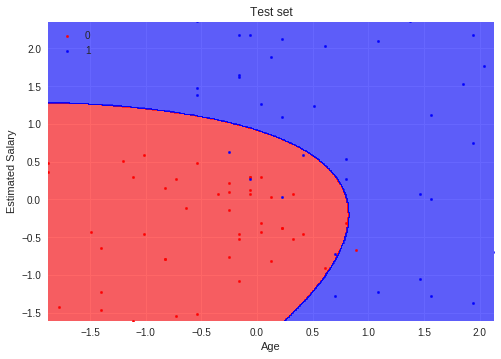

In [15]:
plot_colormap(test_x_values, test_y_values, classifier,'Test set')

### Plotting CAP (Cumulative Accuracy Curve) curve

Accuracy using CAP curve: 0.8571428571428571


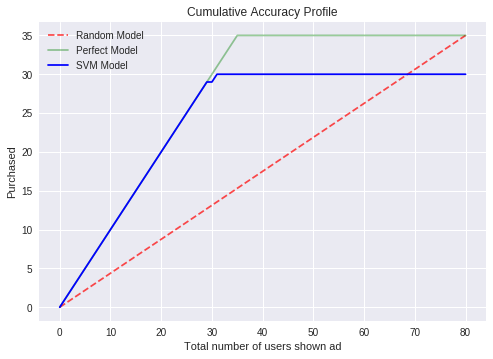

In [16]:
prob = 0.5   # it is default threshold probability for classification in sklearn
plot_cap_curve(test_y_values, test_x_values, classifier, prob, 'Total number of users shown ad', 'Purchased', 'SVM Model')